In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from struct import iter_unpack

# Read from binary

In [2]:
# def read(path):
#     with open(path, 'rb') as f:
#         return [x for x in iter_unpack('<Lff', f.read())]

In [3]:
# solar   = pd.DataFrame(read('./data/solar'),   columns=['datetime', 'voltage (V)', 'current (mA)'])
# battery = pd.DataFrame(read('./data/battery'), columns=['datetime', 'voltage (V)', 'current (mA)'])
# solar   = solar[solar['datetime']>0]
# battery = battery[battery['datetime']>0]
# solar = solar.set_index('datetime')
# solar.index = pd.to_datetime(solar.index, unit='s')
# solar['power (mW)'] = solar['voltage (V)'] * solar['current (mA)']
# battery = battery.set_index('datetime')
# battery.index = pd.to_datetime(battery.index, unit='s')
# battery['power (mW)'] = battery['voltage (V)'] * battery['current (mA)']

# Read from CSV

In [4]:
def parse(data):
    # remove duplicate headers
    data = data.loc[data['time'] != 'time']
    # convert to appropriate datatypes
    data.loc[:,'time'] = pd.to_datetime(data.loc[:,'time'], unit='s')
    data.loc[:,['voltage (V)', 'current (mA)']] = data.loc[:,['voltage (V)', 'current (mA)']].astype(float)
    # set index
    data = data.set_index('time')
    return data

In [5]:
battery = parse(pd.read_csv('data/BATTERY.CSV'))
solar = parse(pd.read_csv('data/SOLAR.CSV'))

/home/jeroen/Documents/projects/BAM_Telecom_grond/venv/lib/python3.5/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/jeroen/Documents/projects/BAM_Telecom_grond/venv/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
battery['power (mW)'] = battery['voltage (V)'] * battery['current (mA)']
solar['power (mW)'] = solar['voltage (V)'] * solar['current (mA)']

# Plot

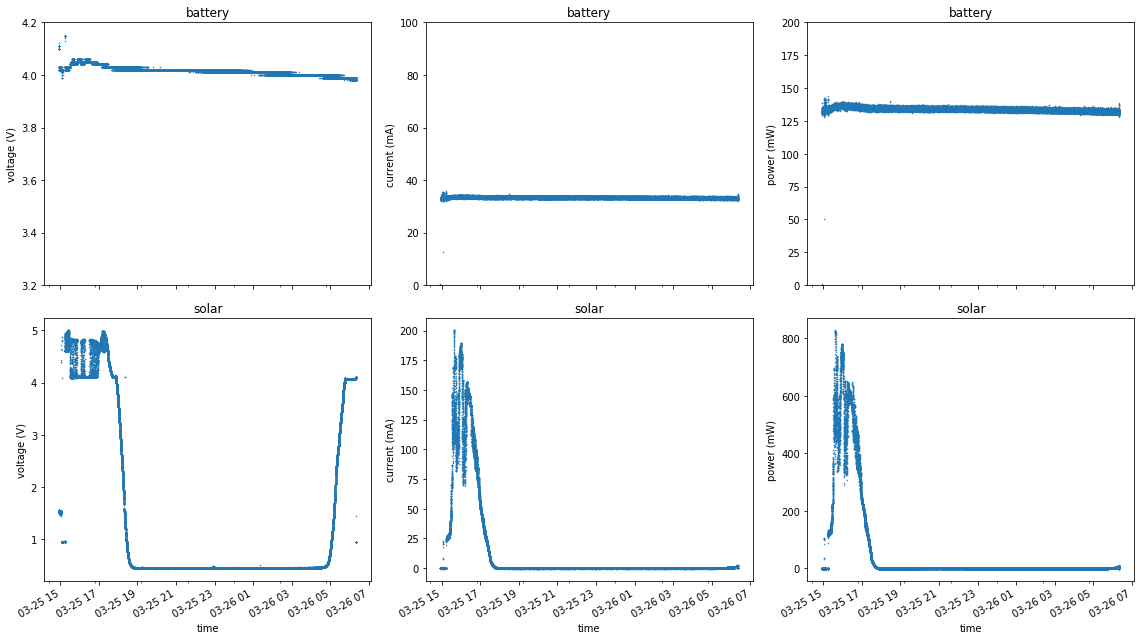

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,9), sharex=True)

for i,x in enumerate([battery, solar]):
    for j in range(3):
        axes[i,j].set_title(['battery', 'solar'][i])
    axes[i,0].set_ylabel('voltage (V)')
    axes[i,1].set_ylabel('current (mA)')
    axes[i,2].set_ylabel('power (mW)')
    x.loc[:, 'voltage (V)'].plot(ax=axes[i,0], style='.', markersize=1)
    x.loc[:, 'current (mA)'].plot(ax=axes[i,1], style='.', markersize=1)
    x.loc[:, 'power (mW)'].plot(ax=axes[i,2], style='.', markersize=1)

axes[0,0].set_ylim([3.2,4.2])
axes[0,1].set_ylim([0,100])
axes[0,2].set_ylim([0,200])

plt.tight_layout()
plt.show()